# An Exploration of Language Prediction: A Simplified Model for Shakespearean Text Generation

The recent advancements in large language models have captivated many, leading to curiosity about the underlying mechanisms of such sophisticated technology. In this context, we propose to explore a fundamental model aimed at predicting Shakespearean text, demonstrating the basic principles of language model training in a simplified manner.

The model is constructed using the following architecture:

- **Embedding Layer**: This layer initializes with the vocabulary size, indicating the range of unique words the model needs to recognize, and an output dimension of 150, designed to create a dense representation of word meanings in a 150-dimensional vector space. The input shape parameter is set based on the sequence length minus one, preparing the model to process sequences of text one word at a time.
  
- **LSTM Layer**: A Long Short-Term Memory (LSTM) layer with 150 units is employed, utilizing a 'tanh' activation function. This choice is due to LSTM's capability to remember and learn from long sequences of data, making it particularly suited for text prediction tasks where the context and order of words are crucial.

- **Dense Layer**: The final layer is a Dense layer with a softmax activation function. It outputs a probability distribution over the vocabulary, indicating the model's prediction for the next word in the sequence.

- **Optimizer**: The Adam optimizer is used with a learning rate of 0.0005, a modification from the default setting intended to mitigate the risk of exploding gradients, thus ensuring more stable training.

The model is compiled with a loss function of 'sparse_categorical_crossentropy' and tracks accuracy as a performance metric. This configuration offers a balance between computational efficiency and the capacity to capture the nuanced structure of Shakespearean English.

This experiment serves as an illustrative example of how even simplistic models can approach the task of language prediction, providing insights into the methodologies that underpin more advanced language processing systems. Through such exploration, we gain a deeper understanding of the challenges and potential of machine learning in linguistic applications.

## Mount Google Drive into Colab and read our dataset

As this model can take quite a while to train (many hours or days depending on your hardware), we will be running this on [Google Colab](https://colab.google/), where we can access quite a bit of cloud GPU time for relatively little money.

We will be saving all results on Google Drive for long term storage, as sessions do not keep any results when they are shutdown.

As the dataset, we will be using [~100,000 lines from Shakespeare plays](https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays).

In [21]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [22]:
import re

def preprocess(s):
    return re.sub(r'[^a-zA-Z ]', '', s).lower()

# Read all lines from alllines.txt which are in quotes, and add to an array.
def read_lines():
    lines = []
    with open('/content/drive/MyDrive/Colab Notebooks/alllines.txt', 'r') as f:
        for line in f:
            if re.match(r'^".*"$', line):
                lines.append(preprocess(line.strip()))
    return lines

## Text tokenization

We start by tokenizing all the text in each line, and then saving the resulting tokenizer. As we will need it at later stages for prediction. We tokenize with the inbuilt [Keras pre-processing tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [23]:
# Use Keras to tokenize the lines.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer.texts_to_sequences(lines), tokenizer

# Read lines and tokenize them.
lines = read_lines()
sequences, tokenizer = tokenize(lines)

# Save the tokenizer
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/shakespeare-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A function to create n-grams

For our model to be able to learn, we need to show it sequences of words (or in our case, integer token representations). We therefore need an n-gram generator for each of our sequences (or lines). This specific n-gram generator produces all possible n-grams from our sequence list (i.e., all lines in the dataset), for each `every_nth` line.

```{note}
n-grams are contiguous sequences of n items from a given sample of text or speech. In the context of natural language processing (NLP), these items are typically words, though they can also be characters or subword units. The concept of n-grams allows models to capture the context up to n-1 words, providing a foundation for predicting subsequent elements in a sequence. This approach is crucial for understanding the linguistic structure and for tasks such as text prediction, where the likelihood of a word's occurrence may depend significantly on the preceding words.

For instance, consider the sentence: "The quick brown fox jumps over the lazy dog." If we were to generate 2-grams (also known as bigrams) for this sentence, we would produce a list of consecutive word pairs: ["The quick", "quick brown", "brown fox", "fox jumps", "jumps over", "over the", "the lazy", "lazy dog"]. Similarly, 3-grams (trigrams) would yield: ["The quick brown", "quick brown fox", "brown fox jumps", "fox jumps over", "jumps over the", "over the lazy", "the lazy dog"]. By examining these n-grams, a model learns the common patterns of word sequences in a language, which aids in predicting what word naturally follows a given sequence.
```

In [24]:
def create_ngrams(sequences, every_nth):
    ngrams = []
    for token_list in sequences[::every_nth]:
        for i in range(1, len(token_list)):
            ngram_sequence = token_list[:i+1]
            ngrams.append(ngram_sequence)
    return ngrams

## An example n-gram output

Here's an example of the generated n-grams for the first five n-grams produced (integers because we are looking at token indices rather than the actual tokens).

In [25]:
ngrams = create_ngrams(sequences, 4)
print(ngrams[0:5])

[[307, 3], [194, 39], [194, 39, 6], [194, 39, 6, 112], [194, 39, 6, 112, 16]]


## Defining the model

We now define the model which aims to harness the power of LSTM (Long Short-Term Memory) networks for the purpose of text prediction, particularly focusing on generating text that mimics the style of Shakespearean English. The model's architecture is designed to understand and replicate the intricate patterns of language use found in Shakespeare's works.

The model begins with an `Embedding` layer, which is essential for converting the integer-encoded vocabulary into dense vectors of fixed size. This layer acts as a lookup table that allows the model to learn a dense representation of words, capturing semantic meanings that are vital for understanding the context of different words in sentences. The `output_dim` parameter is set to 150, indicating that each word is represented by a 150-dimensional vector. The `input_shape` is determined by `seq_len-1`, preparing the model to process sequences of a specific length, minus one for the word to be predicted.

Following the `Embedding` layer, we incorporate an `LSTM` layer with 150 units. LSTM layers are crucial for sequence prediction problems because they can maintain long-term dependencies, overcoming the vanishing gradient problem common in traditional recurrent neural networks (RNNs). The `activation` function used is `tanh`, chosen for its efficacy in LSTMs over alternatives like `relu`, providing a balance between linear and non-linear transformations.

The final layer is a `Dense` layer with a `softmax` activation function. This layer outputs a probability distribution over the entire vocabulary for the next word prediction, based on the context provided by the input sequence. The size of this layer matches the vocabulary size, ensuring each word in the vocabulary can be predicted.

An `Adam` optimizer with a learning rate of `0.0005` is used to compile the model. This reduced learning rate is a deliberate choice to mitigate the risk of exploding gradients, a common issue in training deep neural networks, especially on complex sequence data. The model uses `sparse_categorical_crossentropy` as the loss function, appropriate for this multi-class classification problem, and tracks `accuracy` as a metric to evaluate its performance.

In [26]:
# Create a model with an embeddings layer.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_lstm_model(vocab_size, seq_len):
    model = Sequential(name="LSTM")
    # In Keras3, Embedding doesn't have input_length, instead use input_shape.
    model.add(Embedding(vocab_size, output_dim=150, input_shape=(seq_len-1,)))
    # Explicitly set the activation function to 'tanh', as 'relu' is not recommended for LSTM layers
    model.add(LSTM(150, activation='tanh'))
    model.add(Dense(vocab_size, activation='softmax'))

    # Adjust learning rate to 1/4 of its default value, 0.001 -> 0.00050 - this is to reduce the chance of exploding gradients
    optimizer = Adam(learning_rate=0.0005)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

## Padding sequences

Not all sequences (lines of text) are the same size, but the model requires a constant size for its input. This discrepancy poses a challenge in training neural network models, especially those dealing with language processing. To address this issue, a technique known as padding is employed to standardize the length of sequences.

Padding involves altering the sequences to ensure they all have the same length. This is achieved by adding a special type of token, often referred to as a "pad token," to the sequences that are shorter than the required length. Conversely, sequences that exceed the desired length can be truncated to fit the model's requirements. The choice of where to pad (beginning or end of the sequence) or truncate (beginning or end) can depend on the specific application and the nature of the data.

In practice, padding is applied before feeding the sequences into the model, ensuring that every input sequence has the same shape. This uniformity is crucial for the model to perform batch processing, a computational efficiency technique where multiple sequences are processed simultaneously. Batch processing significantly speeds up the training and inference phases by leveraging parallel computation capabilities.

For instance, consider a scenario where we are training a model on a dataset of sentences with varying lengths, and our model requires each input sequence to have a length of 10 words. A sentence with 8 words would be padded with 2 pad tokens at the end (or the beginning, as per the chosen strategy), while a sentence with 12 words might be truncated to the first (or last) 10 words.

In [27]:
import numpy as np

max_seq_len = max([len(x) for x in ngrams])  # Determine the max length after forming n-grams
padded_sequences = np.array(pad_sequences(ngrams, maxlen=max_seq_len, padding='pre'))
input_sequences = padded_sequences[:, :-1]
target_words = padded_sequences[:, -1]

## Verifying sequences

Once all sequences have been appropriately padded to meet the model's requirements for uniform input size, it becomes crucial to verify the integrity and appropriateness of these modified sequences. Ensuring the correctness of padded sequences involves checking that there are no empty sequences and that sequences are not solely composed of zeros, which represent the padding tokens. This verification step is fundamental to ensuring the model receives meaningful and accurate data for training.

The presence of sequences filled exclusively with pad tokens (zeros) or empty sequences could significantly impact the model's learning process. Such sequences do not provide any valuable information or context that the model can learn from, potentially skewing the training process or leading to biases in the model's predictions. For instance, a model trained on a dataset with a high number of zero-only sequences might become inclined to predict pad tokens more frequently, reducing its overall effectiveness in generating or classifying text.

In [28]:
# Check that the input sequences are not empty, that are not all zeros, and that there are no NaN values. Print an error if they do.
def check_input_sequences(input_sequences):
    print("Checking input sequences...")
    for sequence in input_sequences:
        if len(sequence) == 0 or (len(sequence) == 1 and sequence[0] == 0):
            print("Error: input sequence contains an empty sequence or a sequence of only zeros.")
            return
        for i in sequence:
            if np.isnan(i) or np.isinf(i):
                print("Error: input sequence contains NaN or Inf values.")
                return
    print("Input sequences are valid.")

check_input_sequences(input_sequences)

# Check that the target words are not empty, that are not all zeros, and that there are no NaN values. Print an error if they do.
def check_target_words(target_words):
    print("Checking target words...")
    if len(target_words) == 0 or (len(target_words) == 1 and target_words[0] == 0):
        print("Error: target words contain an empty sequence or a sequence of only zeros.")
        return
    for i in target_words:
        if np.isnan(i) or np.isinf(i) or i == 0:
            print("Error: target words contain 0, NaN or Inf values.")
            return
    print("Target words are valid.")

check_target_words(target_words)

vocab_size = len(tokenizer.word_index) + 1
print("Max sequence length:", max_seq_len)
print("x size:", len(input_sequences))
print("y size:", len(target_words))
print("Vocabulary size:", vocab_size)
print("Example input sequence:", input_sequences[7:9])
print("Example target word:", target_words[7:9])

Checking input sequences...
Input sequences are valid.
Checking target words...
Target words are valid.
Max sequence length: 163
x size: 175704
y size: 175704
Vocabulary size: 27390
Example input sequence: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

## Early stopping and instantiating the model

Overfitting occurs when a model learns the training data too well, capturing noise and outliers in the process, which ultimately leads to poor performance on unseen data. Let's break down the early stopping aspect and then briefly touch on the model creation:

### Early Stopping

**Early stopping** is a form of regularization used to avoid overfitting by halting the training process if the model's performance stops improving on a held-out validation dataset. Here's how the provided `EarlyStopping` callback configuration works:

- **`monitor='loss'`**: This specifies that the callback should monitor the training loss. The objective is to minimize this loss. Monitoring allows the callback to track the performance of the model and make decisions based on it.

- **`patience=5`**: Patience determines the number of epochs with no improvement after which training will be stopped. In this case, training will continue for 5 more epochs without any improvement in the monitored metric (loss) before stopping.

- **`min_delta=0`**: This parameter sets the minimum change in the monitored quantity to qualify as an improvement. Setting it to 0 means any improvement in loss, no matter how small, is considered significant as long as it is a decrease.

- **`mode='min'`**: Since the goal is to minimize the loss, the mode is set to 'min'. This means training will stop when the quantity monitored (loss) has stopped decreasing. If the mode were 'max', it would stop training when the monitored quantity stops increasing (useful for metrics like accuracy).

- **`verbose=1`**: This enables verbose output, which means the epoch at which training stops will be printed to the console.

### LSTM Model Creation

Following the early stopping configuration, the code initializes the LSTM model using a `create_lstm_model` function, which is not fully detailed here but likely constructs a sequential model with LSTM layers. The parameters `vocab_size` and `max_seq_len` suggest the model is designed for text processing, where `vocab_size` indicates the size of the vocabulary (number of unique words) the model can recognize, and `max_seq_len` specifies the length of the input sequences.

- **`batch_size=32`**: This specifies that 32 samples will be processed before the model's internal parameters are updated. Batch size is an important hyperparameter that can affect the convergence and performance of the model.

In [29]:
# Add early stopping to prevent overfitting.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor the training loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    min_delta=0,  # Minimum change in the monitored quantity to qualify as an improvement
    mode='min',  # In 'min' mode, training will stop when the quantity monitored has stopped decreasing
    verbose=1
)

# Create the LSTM model
batch_size = 32
model = create_lstm_model(vocab_size, max_seq_len)
print(model.summary())

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 162, 150)          4108500   
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dense_2 (Dense)             (None, 27390)             4135890   
                                                                 
Total params: 8424990 (32.14 MB)
Trainable params: 8424990 (32.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Training

We finally run the training of our LSTM model with the setup previously discussed, including the early stopping mechanism to prevent overfitting. This process involves feeding the model with our preprocessed and padded sequences of text data, along with their corresponding targets, and allowing it to learn how to predict the next word in a sequence based on its current understanding of the text's structure and content.

In [30]:
import datetime
from keras.callbacks import TensorBoard

# Create a unique name for the log directory based on the current time and set callback
log_dir = "logs/fit/" + model.name + "_" + "batch" + str(batch_size) + "-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(input_sequences,
          target_words,
          batch_size=batch_size,
          epochs=500,
          callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/500
5491/5491 [==============================] - 109s 19ms/step - loss: 6.9633 - accuracy: 0.0431
Epoch 2/500
5491/5491 [==============================] - 90s 16ms/step - loss: 6.3297 - accuracy: 0.0803
Epoch 3/500
5491/5491 [==============================] - 88s 16ms/step - loss: 6.0070 - accuracy: 0.0977
Epoch 4/500
5491/5491 [==============================] - 87s 16ms/step - loss: 5.7569 - accuracy: 0.1085
Epoch 5/500
5491/5491 [==============================] - 87s 16ms/step - loss: 5.5293 - accuracy: 0.1175
Epoch 6/500
...
...
5491/5491 [==============================] - 86s 16ms/step - loss: 1.1493 - accuracy: 0.7512
Epoch 135/500
5491/5491 [==============================] - 86s 16ms/step - loss: 1.1521 - accuracy: 0.7501
Epoch 136/500
5491/5491 [==============================] - 87s 16ms/step - loss: 1.1520 - accuracy: 0.7494
Epoch 137/500
5491/5491 [==============================] - 86s 16ms/step - loss: 1.2544 - accuracy: 0.7220
Epoch 138/500
5491/5491 [===============

## Plotting the training history and saving the model

Let us now plot the training history, and save the model. We are saving the trained model on the Google Drive to ensure it doesn't get deleted once the running session ends.

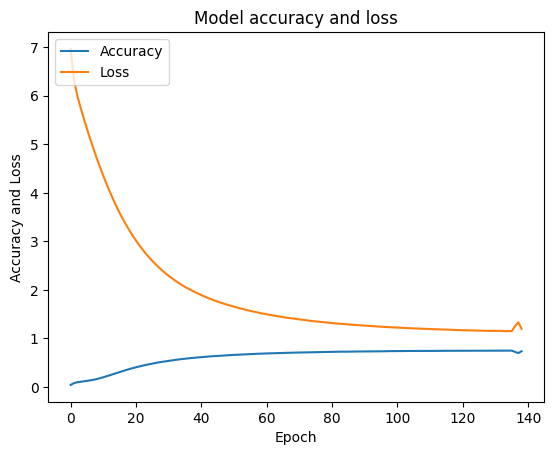

In [31]:
# Plot the training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('Model accuracy and loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss'], loc='upper left')
    plt.show()

plot_training_history(model.history)

# Save the model
model.save("/content/drive/MyDrive/Colab Notebooks/shakespeare-" + model.name + "-embeddings.keras")

## Perform a prediction or two

Finally we can run predictions based on seed inputs, to see how the model performs.

In [47]:
# Load the model, and the tokenizer

from tensorflow.keras.models import load_model
import pickle

model = load_model("/content/drive/MyDrive/Colab Notebooks/shakespeare-" + model.name + "-embeddings.keras")
with open('/content/drive/MyDrive/Colab Notebooks/shakespeare-tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Predict next words based on an input sequence

def predict_next_words(seed_text, next_words, model, max_seq_len, tokenizer):
  for _ in range(next_words):
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
      predicted = model.predict(token_list, verbose=0)
      predicted_class = np.argmax(predicted, axis=-1)
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted_class:
              output_word = word
              break
      seed_text += " " + output_word
  return seed_text

seed_texts = ["My kingdom for", "My daughter is", "If only I were"]
for seed_text in seed_texts:
  next_words = 15
  print(predict_next_words(seed_text, next_words, model, max_seq_len, tokenizer))

My kingdom for you are old and say not be true love you fortunes of good duke of
My daughter is to know you and my sister nothing my lord friend being nothing now of me
If only I were a soldier he is differency between a silver and it from the king henry man


## Final remarks

We could demonstrate very simple, contextual text generation based on a primitive Recurrent Neural Network (RNN). Despite being far from the capabilities of a large language model, we can still illustrate the foundational principles that enable these models to generate text based on learned patterns from a given dataset. Through this simplified example, we aim to shed light on how RNNs can grasp basic language structures and produce text that, while not as sophisticated or coherent as that generated by more advanced models like GPT or BERT, still reflects the initial steps towards understanding and replicating human language.

Our basic RNN, although limited, can be trained on a small dataset of text to learn sequences of words or characters. After training, it can generate new sequences of text by predicting the next word or character based on a given seed text. This process starts with the model receiving an initial input (the seed), processing it to make a prediction, and then feeding the prediction back into the model as part of the next input sequence.